# Importing Libraries

In [1]:
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import tensorflow as tf
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings 
warnings.filterwarnings("ignore")

# Read Data

In [7]:
y = pd.read_csv("Data/org_train.csv", usecols = ["label"])
rem = np.load("Data/train_removed.npy")
y.drop(index = rem, axis = 0, inplace = True)

In [10]:
x1 = pd.read_csv("Data/x_train_1.csv")
x2 = pd.read_csv("Data/x_train_2.csv")
x3 = pd.read_csv("Data/x_train_3.csv")

x1.drop(index = rem, axis = 0, inplace = True)
x2.drop(index = rem, axis = 0, inplace = True)
x3.drop(index = rem, axis = 0, inplace = True)

x1 = np.array(x1)
x2 = np.array(x2)
x3 = np.array(x3)

np.save("Data/x1.npy", x1)
np.save("Data/x2.npy", x2)
np.save("Data/x3.npy", x3)

In [3]:
x = np.load("Data/train_embedding.npy", mmap_mode = 'r')
x1 = np.load("Data/x1.npy", mmap_mode = 'r')
x2 = np.load("Data/x2.npy", mmap_mode = 'r')
x3 = np.load("Data/x3.npy", mmap_mode = 'r')

In [4]:
a = np.memmap("Data/test", dtype = np.float32, mode = 'w+', shape = (len(x1), 101), order = 'F')

In [5]:
a[:, :23] = x1
a[:, 23:30] = x2
a[:, 30:37] = x3
a[:, 37:] = x

In [7]:
Scaler = MinMaxScaler()
temp = a
Scaler.fit(temp)

MinMaxScaler()

In [8]:
x_test_1 = pd.read_csv("Data/x_test_1.csv")
x_test_2 = pd.read_csv("Data/x_test_2.csv")
x_test_3 = pd.read_csv("Data/x_test_3.csv")

rem = np.load("Data/test_removed.npy")
x_test_1.drop(index = rem, axis = 0, inplace = True)
x_test_2.drop(index = rem, axis = 0, inplace = True)
x_test_3.drop(index = rem, axis = 0, inplace = True)

x_test_1 = np.array(x_test_1)
x_test_2 = np.array(x_test_2)
x_test_3 = np.array(x_test_3)

test_embedding = np.load("Data/test_embedding.npy")
y_test = pd.read_csv("Data/org_test.csv", usecols = ["label"])
y_test.drop(index = rem, axis = 0, inplace = True)

x_test = np.hstack((x_test_1, x_test_2, x_test_3, test_embedding))

In [9]:
print("Number of Rows in Test Data =", x_test.shape[0])
print("Number of Columns in Test Data =", x_test.shape[1])

Number of Rows in Test Data = 1501383
Number of Columns in Test Data = 101


In [10]:
# taken from old keras source code
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [12]:
# Loading the ML Model
model = tf.keras.models.load_model("model/model.h5", custom_objects = {"get_f1": get_f1})

In [13]:
y_pred = model.predict(Scaler.transform(x_test))

In [16]:
# Trying 0.42 as Threshold
y_pred = (y_pred > 0.42)

# Model Result

In [17]:
print("Accuracy on Test Data =", accuracy_score(y_test, y_pred) * 100, "%")
print("Precision  on Test Data =", precision_score(y_test, y_pred) * 100, "%")
print("Recall on Test Data =", recall_score(y_test, y_pred) * 100, "%")
print("F1 Score on Test Data =", f1_score(y_test, y_pred))

Accuracy on Test Data = 96.30414091540933 %
Precision  on Test Data = 98.1344898786153 %
Recall on Test Data = 94.41180227359816 %
F1 Score on Test Data = 0.9623715887830186


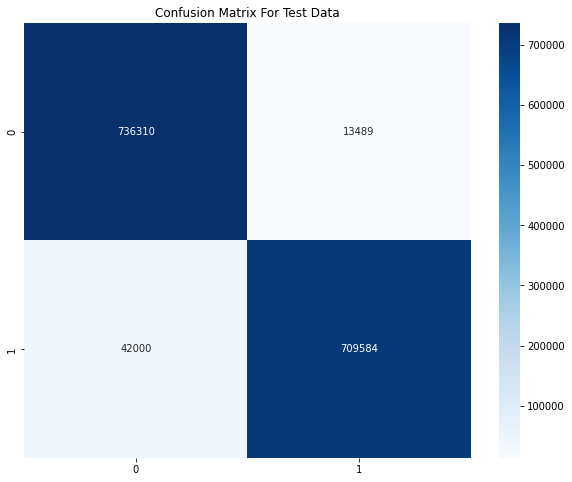

In [18]:
# Getting Confusion matrix for Test Data
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Test Data")
plt.show()

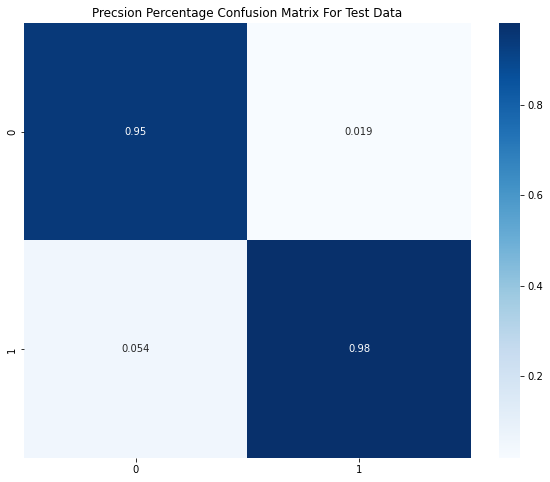

In [19]:
# precision percentage confusion matrix for training data for class 1 and class 0
CM = confusion_matrix(y_test, y_pred)
CM = CM / CM.sum(axis = 0)
plt.figure(figsize = (10, 8))
sns.heatmap(CM, annot = True, cmap = "Blues")
plt.title("Precsion Percentage Confusion Matrix For Test Data")
plt.show()

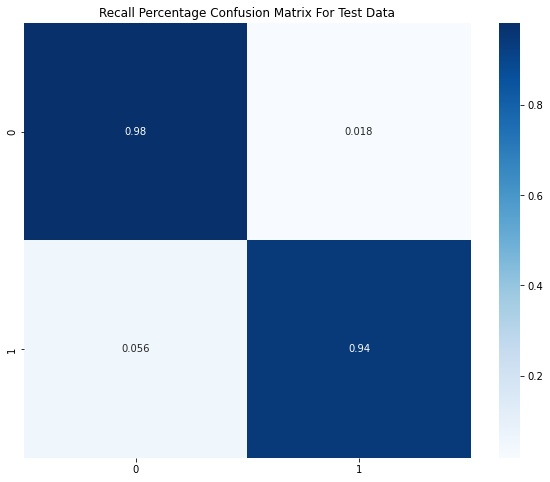

In [20]:
# recall percentage confusion matrix for Test data for class 1 and class 0
CM = confusion_matrix(y_test, y_pred)
CM = ((CM.T) / CM.sum(axis = 1)).T
plt.figure(figsize = (10, 8))
sns.heatmap(CM, annot = True, cmap = "Blues")
plt.title("Recall Percentage Confusion Matrix For Test Data")
plt.show()